In [153]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from pathlib import Path
from os import listdir

In [154]:
BASE_DIR = Path("../log")
BASE_DIR_SAMU = Path("../log_samu")

In [155]:
def process_log_dir(d):
    files = sorted(listdir(d))
    err_files = list(filter(lambda x: "err" in x, files))
    out_files = list(filter(lambda x: "out" in x, files))
    err_files = list(map(lambda x: d / x, err_files))
    out_files = list(map(lambda x: d / x, out_files))
    outs = list(map(lambda x: process_out(x), out_files))
    errs = list(map(lambda x: process_err(x), err_files))
    samples = []
    for o, e in zip(outs, errs):
        for i in range(4):
            assert o[i] == e[i], print(o, e, "There is a mismatch in the output and error files")
        samples.append(o + [e[-1]])
    return samples

def process_out(filepath):
    tmp = filepath.name.split("-")
    processes, threads, place, packs = tmp[1:]
    fitness = []
    time = []
    with open(filepath) as f:
        for line in f:
            if "Execution time" in line:
                time.append(float(line.split(" ")[-1]))
            elif "Best fitness" in line:
                fitness.append(float(line.split(" ")[-1]))
    fitness = min(fitness) if len(fitness) > 0 else np.nan
    time = sum(time) / len(time) if len(time) > 0 else np.nan
    return [int(processes), int(threads), place, int(packs), fitness, time]
def process_err(filepath):
    tmp = filepath.name.split("-")
    processes, threads, place, packs = tmp[1:]
    time = np.nan
    with open(filepath) as f:
        for line in f:
            if 'real' in line:
                tmp = line.split("\t")[-1]
                tmp = tmp.split("m")
                minutes, seconds = float(tmp[0]), float(tmp[1][:-2])
                time = minutes * 60 + seconds
            elif 'job killed' in line:
                time = -1
    return [int(processes), int(threads), place, int(packs), time]
def create_id(x):
    return f"{str(x.processes)}--{str(x.threads)}--{x.place}--{x.packs}"
def mean_time(x):
    return np.nanmean([x.internal_time_fede, x.internal_time_samu])

In [156]:
runs_fede = pd.DataFrame(process_log_dir(BASE_DIR), columns=['processes', 'threads', 'place', 'packs', 'fitness', 'internal_time', 'external_time'])
runs_samu = pd.DataFrame(process_log_dir(BASE_DIR_SAMU), columns=['processes', 'threads', 'place', 'packs', 'fitness', 'internal_time', 'external_time'])

In [157]:
runs_fede['id'] = runs_fede.apply(create_id, axis=1)
runs_fede = runs_fede.drop(columns=['threads', 'processes', 'place', 'packs'])
runs_samu['id'] = runs_samu.apply(create_id, axis=1)
runs_samu = runs_samu.drop(columns=['threads', 'processes', 'place', 'packs'])
runs = runs_fede.merge(
    runs_samu,
    how='outer',
    left_on='id',
    right_on='id',
    suffixes=('_fede', '_samu'),
)
runs['internal_time'] = runs.apply(mean_time, axis=1)
runs['processes'] = runs.id.apply(lambda x: int(x.split("--")[0]))
runs['threads'] = runs.id.apply(lambda x: int(x.split("--")[1]))
runs['place'] = runs.id.apply(lambda x: x.split("--")[2])
runs['packs'] = runs.id.apply(lambda x: int(x.split("--")[3]))

len(runs)

/tmp/ipykernel_155005/677086750.py:47: RuntimeWarning: Mean of empty slice
  return np.nanmean([x.internal_time_fede, x.internal_time_samu])


763

In [158]:
runs[(runs.external_time_samu == -1) & (runs.external_time_fede == -1)].groupby('threads').count()

,fitness_fede,internal_time_fede,external_time_fede,id,fitness_samu,internal_time_samu,external_time_samu,internal_time,processes,place,packs
threads,,,,,,,,,,,
1,0,0,33,33,0,0,33,0,33,33,33
2,0,0,32,32,0,0,32,0,32,32,32
4,0,0,35,35,0,0,35,0,35,35,35
8,0,0,43,43,0,0,43,0,43,43,43
16,0,0,68,68,0,0,68,0,68,68,68
32,0,0,90,90,0,0,90,0,90,90,90
64,0,0,85,85,0,0,85,0,85,85,85


In [159]:
print('|Processes number|Total|Failed|Fail rate|')
print('|-|-|-|-|')
for i in [1, 2, 4, 8, 16, 32, 64]:
    tmp = runs[['processes', 'internal_time']][runs.processes == i]
    t = len(tmp)
    f =len(tmp[tmp.internal_time.isnull()])
    print(f"|{i}|{t}|{f}|{(f/t)*100:.2f}|")

|Processes number|Total|Failed|Fail rate|
|-|-|-|-|
|1|119|20|16.81|
|2|119|56|47.06|
|4|119|62|52.10|
|8|119|68|57.14|
|16|119|73|61.34|
|32|98|70|71.43|
|64|70|57|81.43|


In [160]:
runs_fede = runs_fede.dropna()
runs_samu = runs_samu.dropna()
runs = runs_fede.merge(
    runs_samu,
    how='outer',
    left_on='id',
    right_on='id',
    suffixes=('_fede', '_samu'),
)
runs['internal_time'] = runs.apply(mean_time, axis=1)
runs['processes'] = runs.id.apply(lambda x: int(x.split("--")[0]))
runs['threads'] = runs.id.apply(lambda x: int(x.split("--")[1]))
runs['place'] = runs.id.apply(lambda x: x.split("--")[2])
runs['packs'] = runs.id.apply(lambda x: int(x.split("--")[3]))
len(runs)

357

In [161]:
# There is no consistency across different runs
len(runs[runs.fitness_fede != runs.fitness_samu]), len(runs[runs.fitness_fede == runs.fitness_samu]) 

(285, 72)

In [162]:
runs['fitness_absolute_diff'] = np.abs(runs.fitness_fede - runs.fitness_samu).fillna(0)
runs.fitness_absolute_diff

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
352    0.0
353    0.0
354    0.0
355    0.0
356    0.0
Name: fitness_absolute_diff, Length: 357, dtype: float64

In [163]:
runs.fitness_absolute_diff.mean(), max(runs.fitness_fede.max(), runs.fitness_samu.max()), min(runs.fitness_fede.min(), runs.fitness_samu.min())

(1074.483260602241, 11338.455174, 2499.697508)

In [164]:
runs['time_absolute_diff'] = np.abs(runs.internal_time_fede - runs.internal_time_samu).fillna(0)
runs.time_absolute_diff

0        0.000000
1       90.890047
2      555.720750
3      102.735450
4      152.763305
          ...    
352      0.000000
353      0.000000
354      0.000000
355      0.000000
356      0.000000
Name: time_absolute_diff, Length: 357, dtype: float64

In [165]:
runs.time_absolute_diff.mean(), max(runs.internal_time_fede.max(), runs.internal_time_samu.max()), min(runs.internal_time_fede.min(), runs.internal_time_samu.min())

(402.80901300070036, 24966.224556, 79.11064218750003)

In [167]:
runs.internal_time_fede.mean() / 60

40.54873440330179

In [139]:
runs['total'] = runs.processes * runs.packs
runs[runs.total >= 90]

,fitness_fede,internal_time_fede,external_time_fede,id,fitness_samu,internal_time_samu,external_time_samu,internal_time,processes,threads,place,packs,fitness_absolute_diff,time_absolute_diff,total
189,4307.510438,161.425060,171.796,32--1--pack--3,4307.510438,161.847242,176.180,161.636151,32,1,pack,3,0.000000,0.422181,96
192,4307.510438,161.858728,173.243,32--1--pack_excl--3,4307.510438,161.008513,174.372,161.433621,32,1,pack_excl,3,0.000000,0.850214,96
197,9239.756855,161.425200,172.021,32--2--pack--3,5368.514239,161.976487,173.075,161.700844,32,2,pack,3,3871.242616,0.551287,96
200,6588.665859,161.427331,173.127,32--2--pack_excl--3,6274.592049,161.538376,175.653,161.482854,32,2,pack_excl,3,314.073810,0.111045,96
204,5673.998215,168.162437,177.720,32--4--pack--3,6931.234932,168.133286,181.123,168.147861,32,4,pack,3,1257.236717,0.029151,96
207,7276.183002,168.312806,180.275,32--4--pack_excl--3,8174.067548,168.139727,182.168,168.226267,32,4,pack_excl,3,897.884546,0.173079,96
211,7383.764233,537.199645,548.476,32--8--pack--3,9142.518028,540.912572,551.139,539.056108,32,8,pack,3,1758.753795,3.712927,96
212,3999.495415,547.924488,560.363,32--8--pack_excl--3,7867.844341,538.179921,550.119,543.052204,32,8,pack_excl,3,3868.348926,9.744567,96


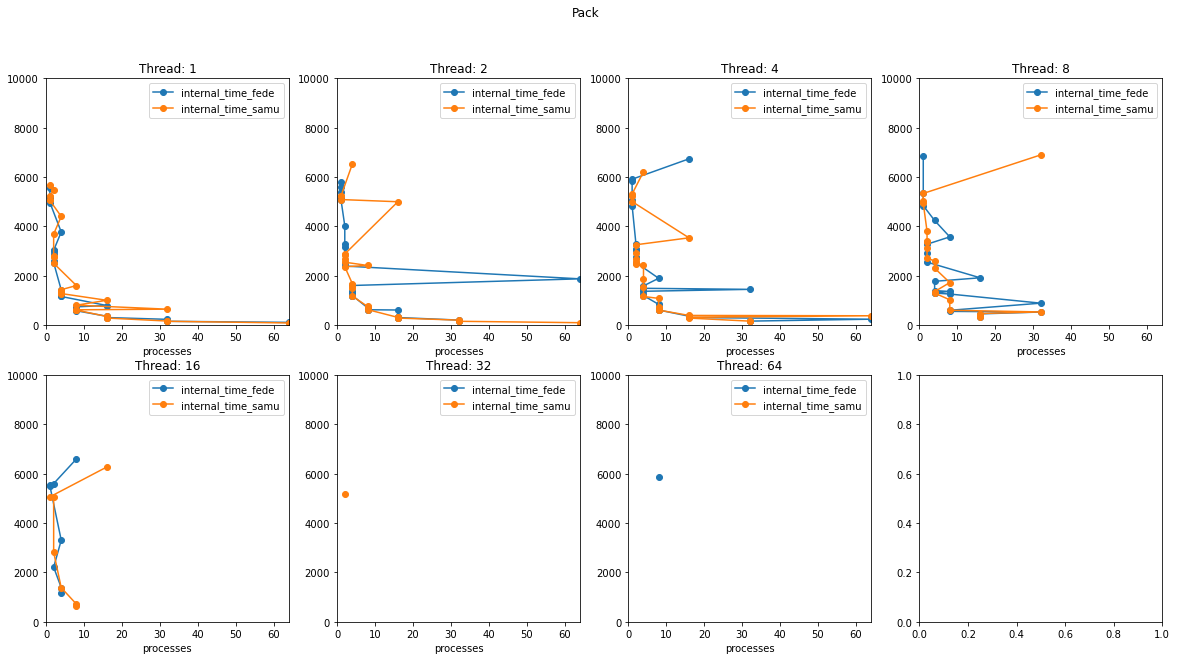

In [102]:
fig, axs = plt.subplots(2,4, figsize=(20, 10))
for i, t in zip(range(4), [1,2,4,8]):
    for s in ['fede', 'samu']:
        runs[(runs.place == 'pack') & (runs.threads == t)].sort_values(f'internal_time_{s}').plot(x='processes', y=f'internal_time_{s}', marker='o', ax=axs[0, i])
    axs[0, i].set_title(f"Thread: {t}")
    axs[0, i].set_xlim([0, 64])
    axs[0, i].set_ylim([0, 10000])
for i, t in zip(range(3), [16, 32, 64]):
    for s in ['fede', 'samu']:
        runs[(runs.place == 'pack') & (runs.threads == t)].sort_values(f'internal_time_{s}').plot(x='processes', y=f'internal_time_{s}', marker='o', ax=axs[1, i])
    axs[1, i].set_title(f"Thread: {t}")
    axs[1, i].set_xlim([0, 64])
    axs[1, i].set_ylim([0, 10000])

plt.suptitle('Pack')
plt.savefig('pack.png')
plt.show()

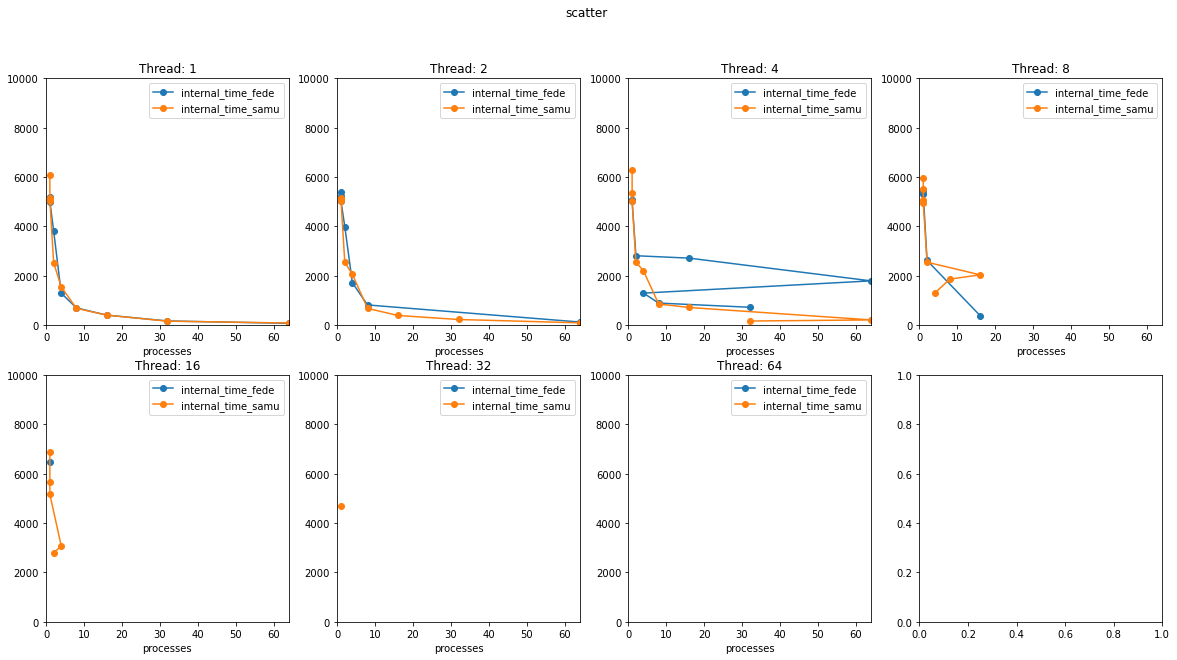

In [103]:
fig, axs = plt.subplots(2,4, figsize=(20, 10))
for i, t in zip(range(4), [1,2,4,8]):
    for s in ['fede', 'samu']:
        runs[(runs.place == 'scatter') & (runs.threads == t)].sort_values(f'internal_time_{s}').plot(x='processes', y=f'internal_time_{s}', marker='o', ax=axs[0, i])
    axs[0, i].set_title(f"Thread: {t}")
    axs[0, i].set_xlim([0, 64])
    axs[0, i].set_ylim([0, 10000])
for i, t in zip(range(3), [16, 32, 64]):
    for s in ['fede', 'samu']:
        runs[(runs.place == 'scatter') & (runs.threads == t)].sort_values(f'internal_time_{s}').plot(x='processes', y=f'internal_time_{s}', marker='o', ax=axs[1, i])
    axs[1, i].set_title(f"Thread: {t}")
    axs[1, i].set_xlim([0, 64])
    axs[1, i].set_ylim([0, 10000])

plt.suptitle('scatter')
plt.savefig('scatter.png')
plt.show()

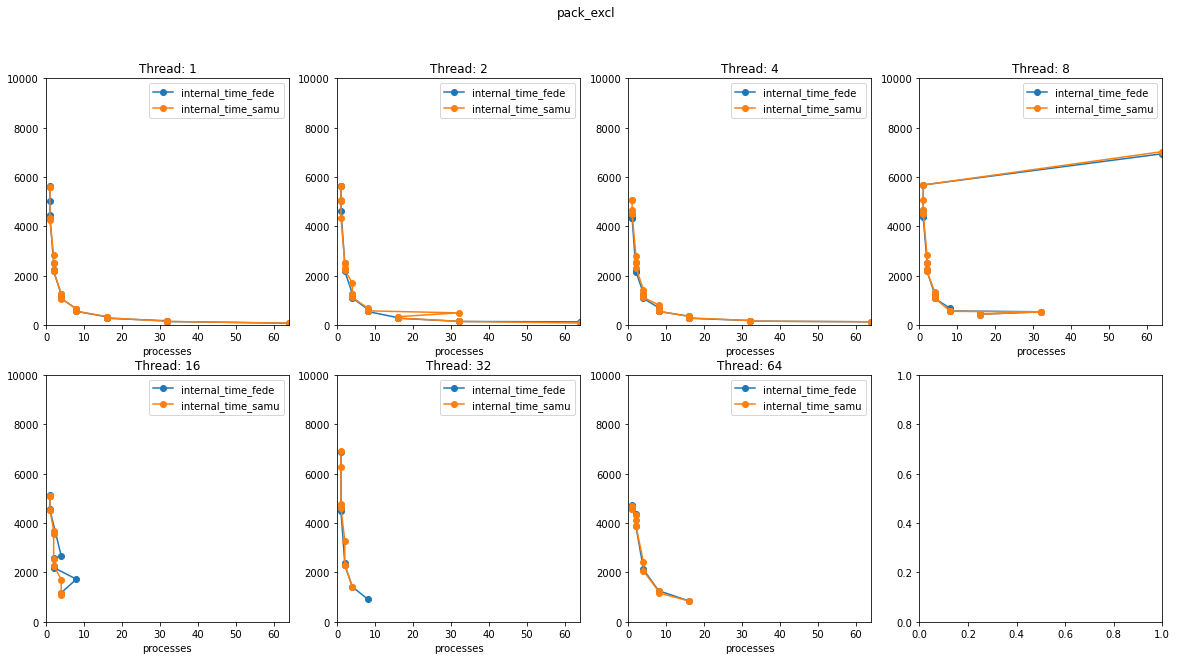

In [104]:
fig, axs = plt.subplots(2,4, figsize=(20, 10))
for i, t in zip(range(4), [1,2,4,8]):
    for s in ['fede', 'samu']:
        runs[(runs.place == 'pack_excl') & (runs.threads == t)].sort_values(f'internal_time_{s}').plot(x='processes', y=f'internal_time_{s}', marker='o', ax=axs[0, i])
    axs[0, i].set_title(f"Thread: {t}")
    axs[0, i].set_xlim([0, 64])
    axs[0, i].set_ylim([0, 10000])
for i, t in zip(range(3), [16, 32, 64]):
    for s in ['fede', 'samu']:
        runs[(runs.place == 'pack_excl') & (runs.threads == t)].sort_values(f'internal_time_{s}').plot(x='processes', y=f'internal_time_{s}', marker='o', ax=axs[1, i])
    axs[1, i].set_title(f"Thread: {t}")
    axs[1, i].set_xlim([0, 64])
    axs[1, i].set_ylim([0, 10000])

plt.suptitle('pack_excl')
plt.savefig('pack_excl.png')
plt.show()

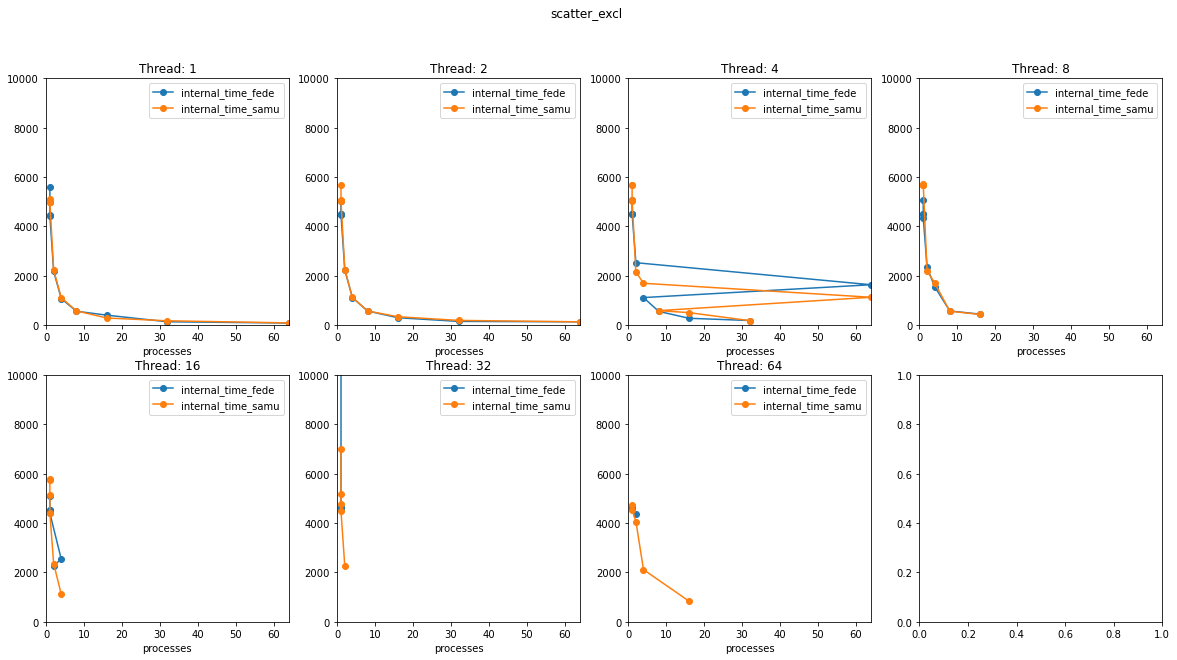

In [105]:
fig, axs = plt.subplots(2,4, figsize=(20, 10))
for i, t in zip(range(4), [1,2,4,8]):
    for s in ['fede', 'samu']:
        runs[(runs.place == 'scatter_excl') & (runs.threads == t)].sort_values(f'internal_time_{s}').plot(x='processes', y=f'internal_time_{s}', marker='o', ax=axs[0, i])
    axs[0, i].set_title(f"Thread: {t}")
    axs[0, i].set_xlim([0, 64])
    axs[0, i].set_ylim([0, 10000])
for i, t in zip(range(3), [16, 32, 64]):
    for s in ['fede', 'samu']:
        runs[(runs.place == 'scatter_excl') & (runs.threads == t)].sort_values(f'internal_time_{s}').plot(x='processes', y=f'internal_time_{s}', marker='o', ax=axs[1, i])
    axs[1, i].set_title(f"Thread: {t}")
    axs[1, i].set_xlim([0, 64])
    axs[1, i].set_ylim([0, 10000])

plt.suptitle('scatter_excl')
plt.savefig('scatter_excl.png')
plt.show()